### Use the LLH Client & Service to produce FreeDOM LLH scans

Intended to demonstrate the LLH service functionality

In [1]:
# run on CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import tensorflow as tf
import numpy as np
import pickle
import json
import math
from matplotlib import pyplot as plt
from llh_service.llh_service import LLHService
from llh_service.llh_client import LLHClient
from multiprocessing import Process

In [3]:
with open('test_data/test_event.pkl', 'rb') as f:
    event = pickle.load(f)

In [4]:
with open('llh_service/service_params.json') as f:
    params = json.load(f)

In [5]:
# tweak some parameters for this notebook
params['hitnet_file'] = 'models/HitNet_08_May_2020-16h02/epoch_3675_model.hdf5'
params['chargenet_file'] = 'models/ChargeNet_08_May_2020-15h59/epoch_600_model.hdf5'
params['req_addr'] = 'tcp://127.0.0.1:12345'
params['ctrl_addr'] = 'tcp://127.0.0.1:12346'
params['batch_size']= {'n_hypos': 2500, 'n_observations': 40000}

In [6]:
# start the service in a separate process
def start_service(params):
    with LLHService(**params) as serv:
        print('starting work loop...')
        serv.start_work_loop()
        
    print('done')

proc = Process(target=start_service, args=(params,))
proc.start()

starting work loop...
Received die command... flushing and exiting
cleaning up
done


In [7]:
# construct the client
client = LLHClient(
                    req_addr=params["req_addr"],
                    batch_size=params["batch_size"],
                    n_hypo_params=params["n_hypo_params"],
                    n_obs_features=params["n_obs_features"]
                  )

In [8]:
# synchronous eval will block until the service is ready
client.eval_llh(event['hits'].flatten(), event['params'].flatten(), timeout=60000)

-48.691635

In [9]:
# convenience function for synchronous batch evaluations
def llh(x, theta):
    client.request_batch_eval(x.flatten(), theta.flatten())
    return client.recv()['llh']

In [10]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

# utility function to map out a 2d NLL slice
def map_2d(inds, steps, llh_func, batch_size=2500, pulses=event['hits'], base_params=event['params']):
    mg = np.meshgrid(*steps)
    
    output = np.empty(mg[0].size, np.float32)
    
    param_table = np.repeat(base_params[np.newaxis, :], batch_size, axis=0)
    
    n_filled = 0
    while n_filled < output.size:
        for ind, coord in zip(inds, mg):
            param_table[:, ind] = coord.flat[n_filled:n_filled + batch_size]
        output[n_filled:n_filled + batch_size] = llh_func(pulses, param_table)
        n_filled += batch_size
        
    return output.reshape([step.size for step in steps[::-1]])

def plot_2d(inds, steps, true_params, llh_func, ax):
    llh_map = map_2d(inds, steps, llh_func)

    delta = llh_map - llh_map.min()
    
    im = ax.pcolormesh(*steps, delta, cmap='Spectral', 
                       rasterized=True, linewidth=0)    
    colorbar(im)
    
    mle_y, mle_x = np.unravel_index(np.argmin(llh_map), llh_map.shape)
    
    ax.axhline(steps[1][mle_y])
    ax.axvline(steps[0][mle_x])
    
    ax.plot(*[[p] for p in true_params], 'w*')

In [11]:
true_params = event['params']

par_names = ['x', 'y', 'z', 'time',
             'azimuth', 'zenith', 
             'cascade energy', 'track energy']

par_pairs = [(0, 1), (0, 2), (1, 2), (3, 2),
             (4, 5), (4, 2), (4, 0), (6, 7)
            ]

gridsize=100
spacings = [np.linspace(true_params[0]-50, true_params[0]+50, 100),
            np.linspace(true_params[1]-50, true_params[1]+50, 100),
            np.linspace(true_params[2]-50, true_params[2]+50, 100),
            np.linspace(true_params[3]-300, true_params[3]+300, 100),
            np.linspace(0, 2*math.pi, 100),
            np.linspace(0, math.pi, 100),
            np.logspace(-1, 2, 100),
            np.logspace(-1, 2, 100)
           ]

CPU times: user 1.52 s, sys: 56 ms, total: 1.58 s
Wall time: 3 s


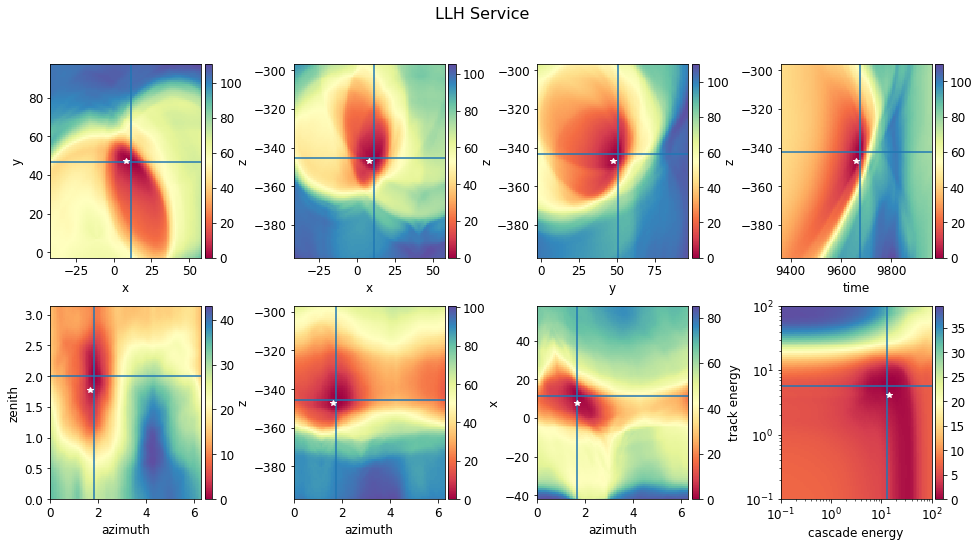

In [12]:
%%time
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.25)

axiter = axes.flat
for i, ax in enumerate(axiter):
    ind0, ind1 = par_pairs[i]
    grid_spacing = (spacings[ind0], spacings[ind1])
    plot_2d((ind0, ind1), grid_spacing, (true_params[ind0], true_params[ind1]), llh, ax)
    ax.set_xlabel(par_names[ind0], fontsize=12)
    ax.set_ylabel(par_names[ind1], fontsize=12)
    ax.tick_params(labelsize=12)
    
    if par_names[ind0].endswith('energy'):
        ax.set_xscale('log')
    if par_names[ind1].endswith('energy'):
        ax.set_yscale('log')
    
fig.suptitle('LLH Service', fontsize=16)
fig.savefig('llh_service_maps.pdf', bbox='tight')

In [13]:
# time it
t = %timeit -o output = map_2d((0,1), (spacings[0], spacings[1]), llh)

139 ms ± 5.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
print(f'time per eval is {t.average/gridsize**2*1e6:.2f} usec')

time per eval is 13.94 usec


In [15]:
# kill the service
import zmq
ctrl_sock = zmq.Context.instance().socket(zmq.PUSH)
ctrl_sock.connect(params["ctrl_addr"])
ctrl_sock.send_string("die")
proc.join()